In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/question-pairs-dataset/questions.csv
/kaggle/input/contractions/contractions.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz, process
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score,accuracy_score

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df_train = pd.read_csv('/kaggle/input/question-pairs-dataset/questions.csv')
df_train.shape

(404351, 6)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


## Analysing out Target column, "is_duplicated" and checking how unbalanced our data is.

In [5]:
percent_duplicate_ques = df_train.is_duplicate.value_counts()[0]/df_train['is_duplicate'].count()
percent_nonduplicate_ques = 1 - percent_duplicate_ques

print(percent_duplicate_ques)
print(percent_nonduplicate_ques)

0.6307515005527375
0.36924849944726246


<AxesSubplot: xlabel='is_duplicate', ylabel='count'>

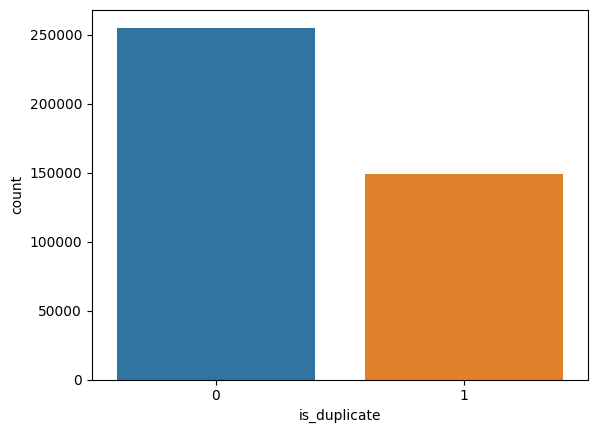

In [6]:
sns.countplot(x = df_train['is_duplicate'])

# Handling Missing Data

In [7]:
df_train[df_train['question1'].isna()]

,id,qid1,qid2,question1,question2,is_duplicate
363416,363416,711434,711435,NaN,My Chinese name is Haichao Yu. What English na...,0


In [8]:
df_train[df_train['question2'].isna()]

,id,qid1,qid2,question1,question2,is_duplicate
105796,105796,209841,209842,How can I develop android app?,NaN,0
201871,201871,398348,398349,How can I create an Android app?,NaN,0


We have all total 3 missing values in a dataset of 4 lakh rows, so we are simply dropping them 

In [9]:
df_train.dropna(inplace = True)
df_train.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

### ***Since the dataset is huge, for faster execution, we will randomly select 40,000 rows.***

In [10]:
df = df_train.sample(40000)

### Again checking whether sample dataset is balance or not.

In [11]:
percent_duplicate_samp_ques = df.is_duplicate.value_counts()[0]/df['is_duplicate'].count()
percent_nonduplicate_samp_ques = 1 - percent_duplicate_ques
print(percent_duplicate_samp_ques)
print(percent_nonduplicate_samp_ques)

0.62825
0.36924849944726246


<AxesSubplot: xlabel='is_duplicate', ylabel='count'>

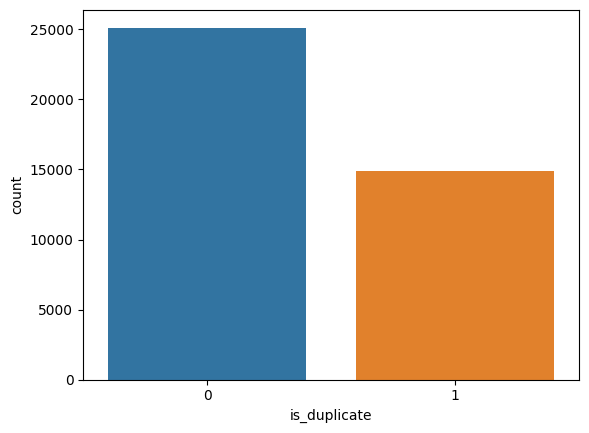

In [12]:
sns.countplot(x = df['is_duplicate'])

## Preprocessing the Text

### Loading contractions.csv which contains "List of English contractions".

In [13]:
contractions = pd.read_csv('/kaggle/input/contractions/contractions.csv')
contractions.index = contractions['Contraction']
contractions_dict = contractions.to_dict()['Meaning']

In [14]:
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'

In [15]:
def preprocess_apply(text):

    text = str(text).lower().strip()
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    # Replace all URls with 'url'
    text = re.sub(urlPattern,'url',text)
    # Replace @USERNAME to 'user'.
    text = re.sub(userPattern,'user', text)
    # The pattern '[math]' appears around 900 times in the whole dataset.
    text = text.replace('[math]', '')
    
    for contraction, replacement in contractions_dict.items():
        text = text.replace(contraction, replacement)
    text = text.replace("'ve", " have")
    text = text.replace("n't", " not")
    text = text.replace("'re", " are")
    text = text.replace("'ll", " will")
    
    # Removing HTML tags
    text = BeautifulSoup(text)
    text = text.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    text = re.sub(pattern, ' ', text).strip()

    return text

In [16]:
preprocess_apply("@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.")

'at nationwideclass no  it is not behaving at all  i m mad  why am i here  because i cannot see you all over there'

Preprocessing question1 and question2 columns

In [17]:
df['question1'] = df['question1'].apply(preprocess_apply)
df['question2'] = df['question2'].apply(preprocess_apply)
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
371896,371896,727698,726205,how can we identify a metal as cast iron,cookware how should cast iron pots be cleaned,0
136971,136971,271188,271189,can i tell that i am going to pursue agricultu...,can i pursue one year mba after completing mba...,0
200052,200052,394794,394795,what are your views on demonetization of 500 a...,why narendra modi banned 500 and 1000 notes in...,1
68066,68066,135312,135313,which book is best for study of gre,what is the best book for gre exam,1
4956,4956,9907,9908,what does it mean to be a writer,what does it mean to be a creative writer,0


## Feature Creation

**q1_len** : Character length of question1.

**q2_len** : Character length of question2.


In [18]:
df['q1_len'] = df['question1'].str.len() 
df['q2_len'] = df['question2'].str.len()

**q1_n_words** : word length of question1

**q2_n_words** : word length of question2

In [19]:
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

**common_words** : words common in both the questions.

In [20]:
def common_words(row):
    w1 = set(row['question1'].split(" "))
    w2 = set(row['question2'].split(" "))   
    return  len(w1 & w2)

df['common_words_len'] = df.apply(common_words, axis=1)

**word_share** : Common words / Total words in questions and question2

In [21]:
df['word_share'] = df['common_words_len']/(df['q1_n_words'] + df['q2_n_words'])

## Advance Feature engineering

### **Token Features**

**cwc_min**: This is the ratio of the number of common words to the length of the smaller question

**cwc_max**: This is the ratio of the number of common words to the length of the larger question

**csc_min**: This is the ratio of the number of common stop words to the smaller stop word count among the two questions

**csc_max**: This is the ratio of the number of common stop words to the larger stop word count among the two questions

**ctc_min**: This is the ratio of the number of common tokens to the smaller token count among the two questions

**ctc_max**: This is the ratio of the number of common tokens to the larger token count among the two questions

**last_word_eq**: 1 if the last word in the two questions is same, 0 otherwise

**first_word_eq**: 1 if the first word in the two questions is same, 0 otherwise

In [22]:
def get_token_features(df):
    
    q1 = df['question1']
    q2 = df['question2']
    
    STOPWORDS = stopwords.words('english')
    SAFE_DIV = 0.01
    token_features = [0.0]*8
    
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    #Get words other than stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOPWORDS])
    q2_words = set([word for word in q2_tokens if word not in STOPWORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOPWORDS])
    q2_stops = set([word for word in q2_tokens if word in STOPWORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [23]:
token_features = df.apply(get_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

**Fuzzy Features**

**fuzz_ratio**: fuzz_ratio score from fuzzywuzzy

**fuzz_partial_ratio**: fuzz_partial_ratio from fuzzywuzzy

**token_sort_ratio**: token_sort_ratio from fuzzywuzzy

**token_set_ratio**: token_set_ratio from fuzzywuzzy

For better understanding of fuzzy features : https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

In [24]:
# pip install fuzzywuzzy

In [25]:
# Fuzzy Features
def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.ratio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features


In [26]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [27]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_len', 'q2_len', 'q1_n_words', 'q2_n_words', 'common_words_len',
       'word_share', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'last_word_eq', 'first_word_eq', 'fuzz_ratio',
       'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio'],
      dtype='object')

## EDA

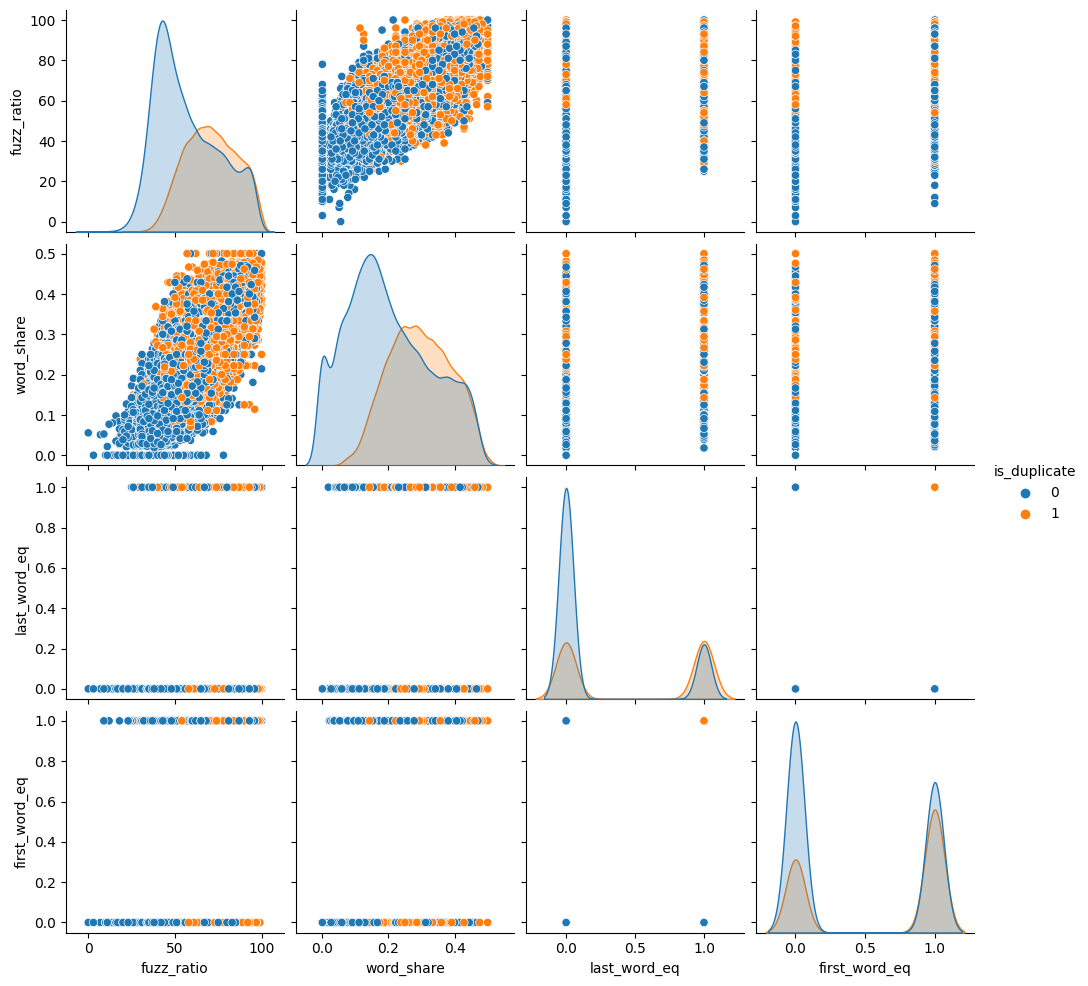

In [28]:
sns.pairplot(df[['fuzz_ratio', 'word_share', 'last_word_eq', 'first_word_eq','is_duplicate']], hue='is_duplicate')

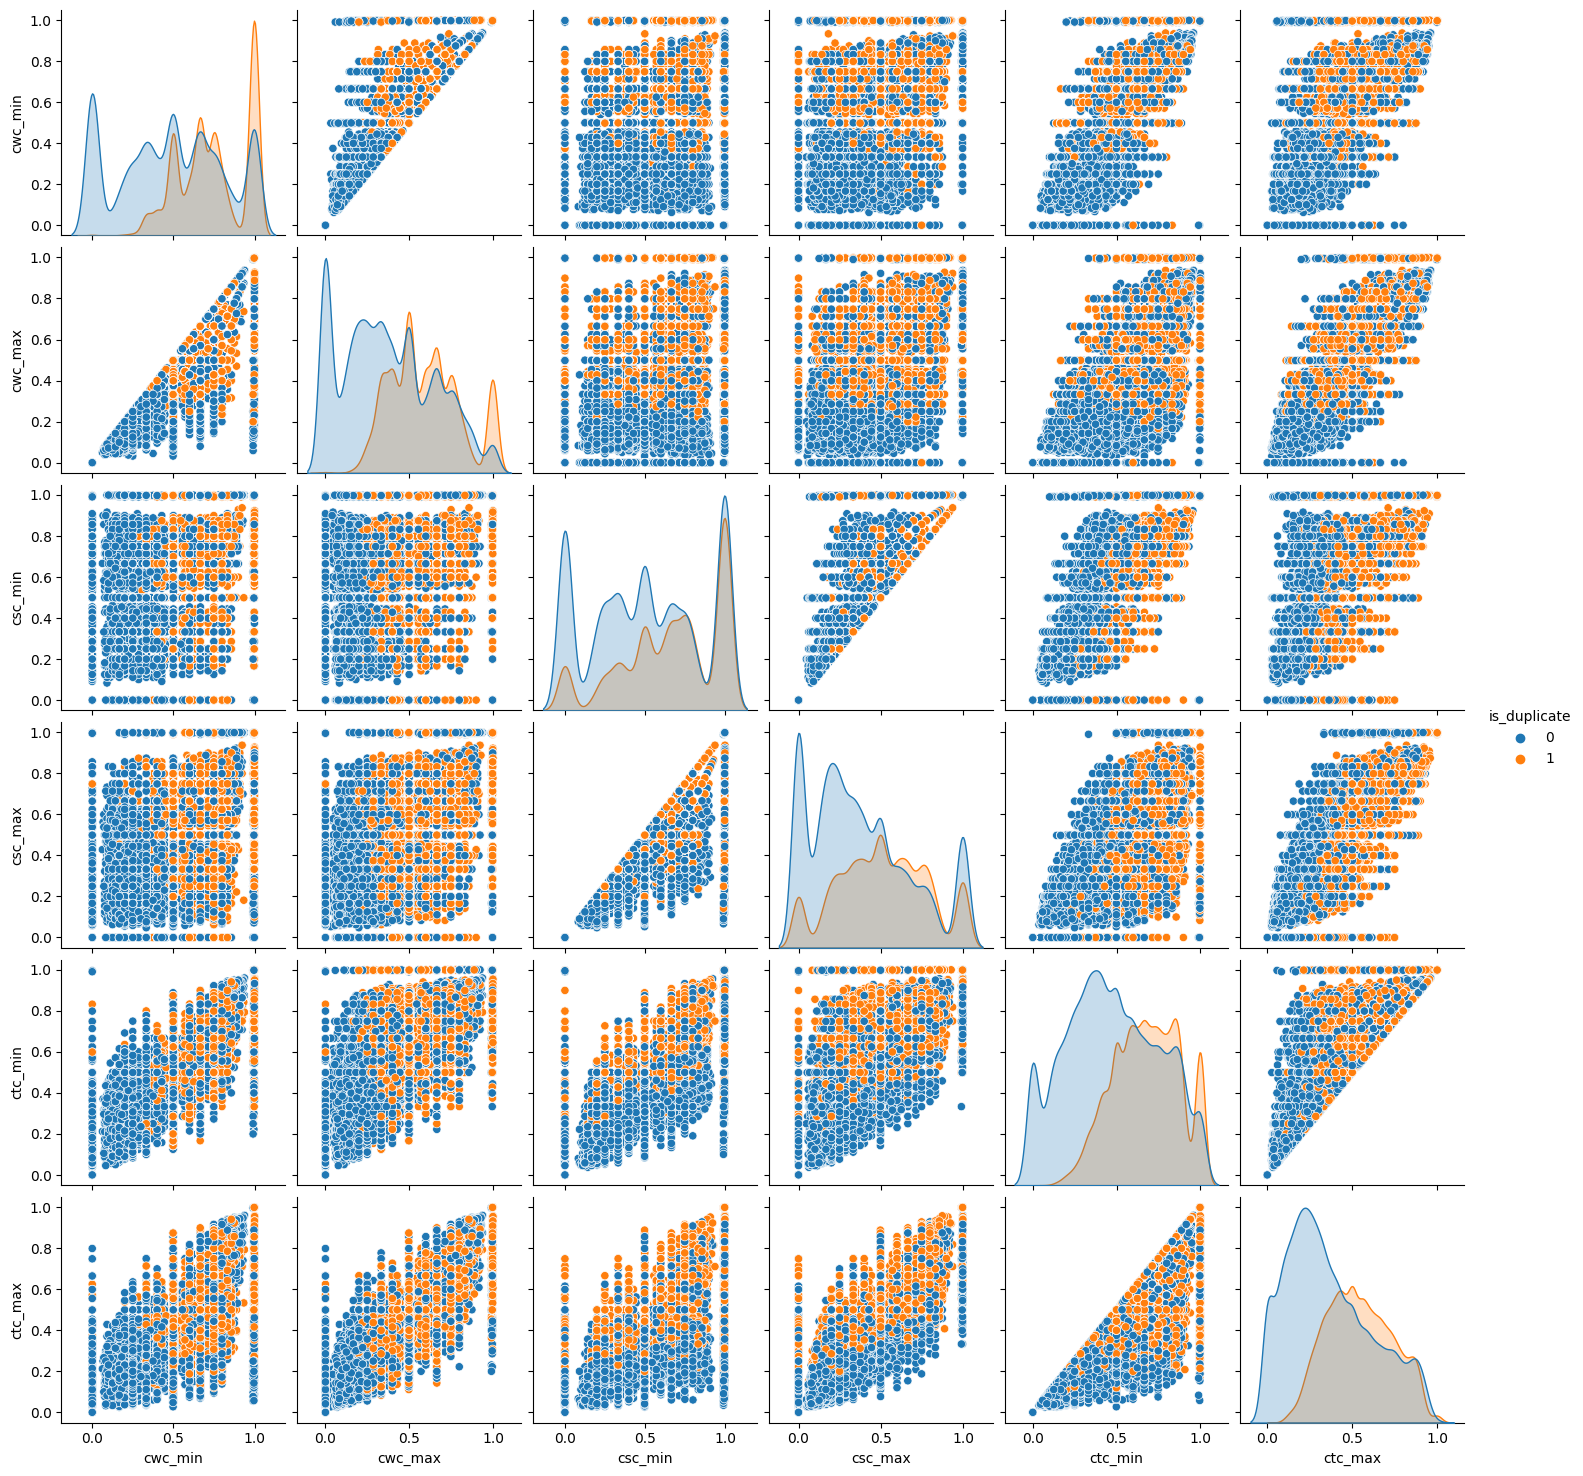

In [29]:
sns.pairplot(df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max','is_duplicate']],hue='is_duplicate')

<AxesSubplot: xlabel='word_share', ylabel='Density'>

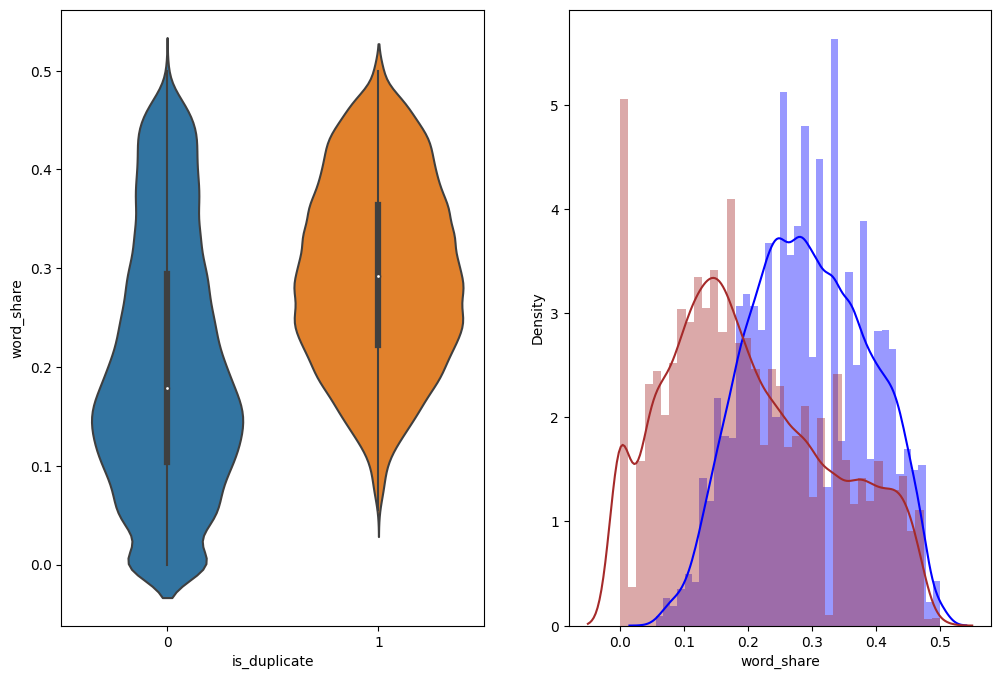

In [30]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df)
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'], color = 'blue')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'], color = 'brown')

## **Stemming**

In [31]:
stemmer = PorterStemmer()

def stem_sentence(sentence):

    # Tokenize the sentence into words
    words = nltk.word_tokenize(sentence)
    
    # Apply stemming to each word in the sentence
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Join the stemmed words back into a sentence
    stemmed_sentence = ' '.join(stemmed_words)
    return stemmed_sentence

# Apply stemming to the 'question1' column in the DataFrame
df['stemmed_question1'] = df['question1'].apply(stem_sentence)
df['stemmed_question2'] = df['question2'].apply(stem_sentence)

## Applying BOW (Bag of words)

In [32]:
questions = list(df['stemmed_question1']) + list(df['stemmed_question2'])

In [33]:
cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)
bow_q1 = pd.DataFrame(q1_arr, index= df.index)
bow_q2 = pd.DataFrame(q2_arr, index= df.index)
bow_df = pd.concat([bow_q1,bow_q2], axis = 1)

In [34]:
new_df = pd.concat([df, bow_df], axis = 1)
new_df.columns = new_df.columns.astype(str)

In [35]:
new_df.columns[:2]

Index(['id', 'qid1'], dtype='object')

## **Splitting Training and Testing Data**

In [36]:
X = new_df.drop(['question1','question2','qid1','qid2','id','stemmed_question1','stemmed_question2','is_duplicate'], axis = 1)
y = new_df['is_duplicate']
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2,random_state = 42)

### **Applying Random Forest Model**

In [37]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.800375

### **Logistic Regression Model**

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
clf = LogisticRegression(C = 1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.734875

In [39]:
# from tqdm import tqdm
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score

# # Initialize and train the SVC classifier
# with tqdm(total=len(X_train)) as pbar:
#     svc = SVC()
#     svc.fit(X_train, y_train)

# # Predict on the test set
# y_pred = svc.predict(X_test)

# # Evaluate the accuracy of the classifier
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)


## **TF-IDF**

In [40]:
questions = list(df['stemmed_question1']) + list(df['stemmed_question2'])
vectorizer = TfidfVectorizer(max_features=1000)

q1_arr, q2_arr = np.vsplit(vectorizer.fit_transform(questions).toarray(),2)
tf_q1 = pd.DataFrame(q1_arr, index= df.index)
tf_q2 = pd.DataFrame(q2_arr, index= df.index)
tf_df = pd.concat([tf_q1,tf_q2], axis = 1)

In [41]:
tfidf_df = pd.concat([df, tf_df], axis = 1)
X_tfidf = tfidf_df.drop(['question1','question2','qid1','qid2','id','stemmed_question1','stemmed_question2','is_duplicate'], axis = 1)
y_tfidf = tfidf_df['is_duplicate']

X_tfidf.columns = X_tfidf.columns.astype(str)
X_train_tfidf,X_test_tfidf,y_train_tfidf,y_test_tfidf = train_test_split(X_tfidf, y_tfidf ,test_size=0.2,random_state = 42)

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier()
rf.fit(X_train_tfidf,y_train_tfidf)
y_pred_tfidf = rf.predict(X_test_tfidf)

accuracy_score(y_test_tfidf,y_pred_tfidf)

0.793125

### ***Finally decided to vectorize with bag of words and use Random Forest Classifier to train the model.***

### **Hyperparameter tuning Random Forest and plotting AUC-ROC curve.**

Accuracy: 0.800875


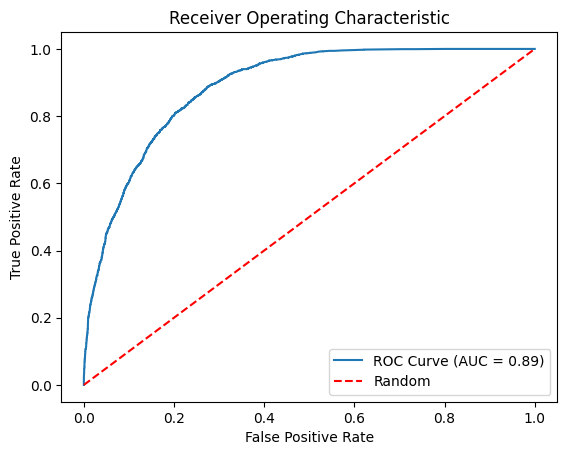

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc


# Define the parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini'],
    'n_estimators': [150],
    'max_depth': [120],
    'max_features': ['sqrt']
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier()

# Perform grid search cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=4)
grid_search.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

y_proba = grid_search.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_proba)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

In [44]:
import pickle

pickle.dump(grid_search, open('model.pkl','wb'))
pickle.dump(cv, open('cv.pkl','wb'))

In [45]:
stopwords = stopwords.words("english")
pickle.dump(stopwords,open('stopwords.pkl','wb'))

## **Preparing Complete E2E Model**

In [46]:
def preprocess(q):
    
    # convert to lower case
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Replace all URls with 'url'
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
    q = re.sub(urlPattern,'url',q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

         
    for contraction, replacement in contractions.items():
        q = q.replace(contraction, replacement)

    

    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [47]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)


def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))


def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001
    
    nltk.download('stopwords')
    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features



def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features


def stemming_and_bow(question):
    
    stemmer = PorterStemmer()
    words = nltk.word_tokenize(question)
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Join the stemmed words back into a sentence
    stemmed_question = ' '.join(stemmed_words)

    ques_vector = cv.transform([stemmed_question]).toarray()
    
    return ques_vector





def query_point_creator(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1

    q1_bow = stemming_and_bow(q1)
    q2_bow = stemming_and_bow(q2)
    
    # bow feature for q2
     
    return np.hstack((np.array(input_query).reshape(1,18),q1_bow,q2_bow))

In [50]:
q1 = 'What should I buy cooler or AC?'
q2 = 'Is Ac better than cooler'
grid_search.predict(query_point_creator(q1,q2))


array([0])

## Created complete End to End project and deployed this model on Streamlit app : 

## https://duplicate-question.streamlit.app/




### **Thank You**